# Topological Data Analysis on Well-Trained Neural Networks for Binary Classification.

#### Author: Adam Goeddeke
#### Supervised by: Professor Thomas Fiore
#### Institution: University of Michigan - Dearborn 

We begin by importing all the necessary packages and libraries. 

In [1]:
import tensorflow as tf
import numpy as np
import tensorflow.keras as keras
import gudhi as gd
import gudhi.representations
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random as r
import sklearn
from mpl_toolkits import mplot3d
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA 
from keras.models import Sequential

# The below line of code will allow the PCA graphs 
# to be freely spun by clicking and dragging in 
# the direction you wish to spin.

# %matplotlib notebook

We now read in and examine the data set. It contains information about grey-scale images of a banknote (variance, skewness, curtosis, and entropy) as well as whether or not it is a genuine or a counterfit bill (class). The information about the bill has to do with the way the images were converted into numbers i.e. Wavelet Transformed Image. The data set and information about the dataset can be found here:

https://archive.ics.uci.edu/ml/datasets/banknote+authentication#

Here, the "class" column is our target where 0 represents a fake bill and 1 represents a genuine bill. We also have "variance," "skewness," "curtosis," and "entropy" as our attributes. Our neural network will have an input layer with four nodes (one for each attribute) and an output layer with one node (the predicted class). This is a binary classification problem, thus the output node should be a 1 or a 0. If it is not one of the two values exactly, we shall consider a difference of 0.01 to be sufficient criteria to round up or down. 

In [2]:
df = pd.read_csv("data_banknote_authentication.csv")

In [3]:
print(f"{df}\n")   # Print the first 5 rows of df. 
print(f"{df.info()}\n")   # Print the general information of df.

      variance  skewness  curtosis  entropy  class
0      3.62160   8.66610   -2.8073 -0.44699      0
1      4.54590   8.16740   -2.4586 -1.46210      0
2      3.86600  -2.63830    1.9242  0.10645      0
3      3.45660   9.52280   -4.0112 -3.59440      0
4      0.32924  -4.45520    4.5718 -0.98880      0
...        ...       ...       ...      ...    ...
1367   0.40614   1.34920   -1.4501 -0.55949      1
1368  -1.38870  -4.87730    6.4774  0.34179      1
1369  -3.75030 -13.45860   17.5932 -2.77710      1
1370  -3.56370  -8.38270   12.3930 -1.28230      1
1371  -2.54190  -0.65804    2.6842  1.19520      1

[1372 rows x 5 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372 entries, 0 to 1371
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   variance  1372 non-null   float64
 1   skewness  1372 non-null   float64
 2   curtosis  1372 non-null   float64
 3   entropy   1372 non-null   float64
 4   class     1372 no

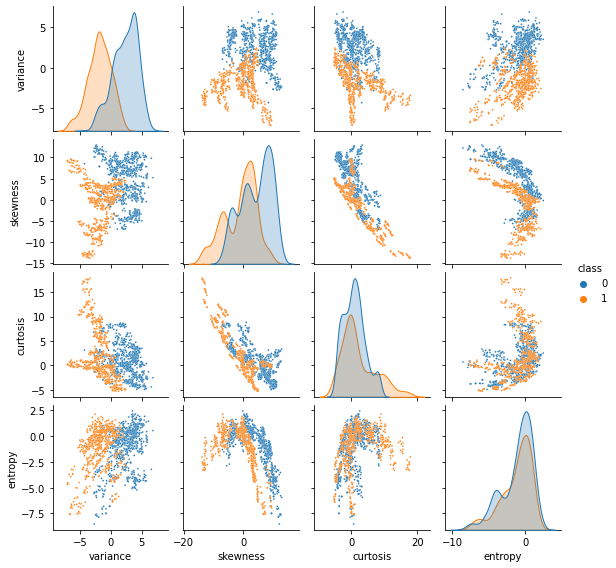

In [4]:
# Display a pairplot separated by class
sns.pairplot(df, hue='class', height=2, plot_kws={"s":3})

<AxesSubplot:xlabel='class', ylabel='count'>

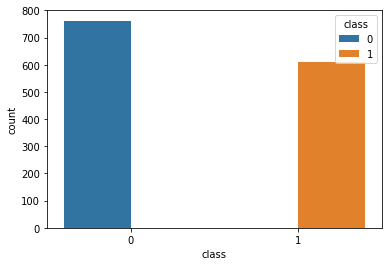

In [5]:
# Display the number of counterfeit and genuine banknotes 
sns.countplot(x='class', hue='class', data=df)

As we can see, we have 152 more counterfit bills than we do genuine. In order to not have any bias in our dataset, we will randomly remove 152 of the counterfit bills. 

In [6]:
rand_arr = r.sample(range(0, 152), 152)
df = df.drop(rand_arr)

In [7]:
df_genuine = df[df['class'] == 1]
df_counterfeit = df[df['class'] == 0]

print("Number of genuine bills: ", end="")
print(df[df['class'] == 1]['class'].count())

print("Number of couterfit bills: ", end="")
print(df[df['class'] == 0]['class'].count())

print("Total number of bills: ", end="")
print(df[df['class'] == 0]['class'].count() + df[df['class'] == 1]['class'].count())

Number of genuine bills: 610
Number of couterfit bills: 610
Total number of bills: 1220


<AxesSubplot:>

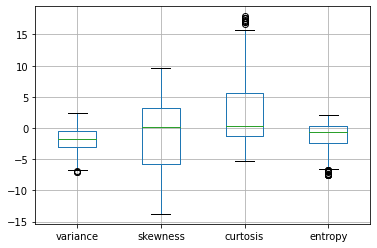

In [8]:
# Box plot for genuine bills
pd.DataFrame(df_genuine).drop('class', axis=1).boxplot() 

<AxesSubplot:>

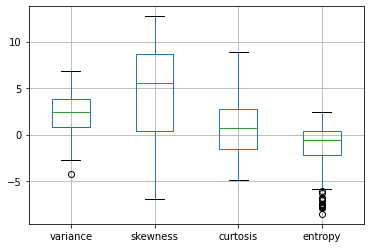

In [9]:
# Box plot for counterfeit bills
pd.DataFrame(df_counterfeit).drop('class', axis=1).boxplot() 

We now split the data set into attributes (variance, skewness, curtosis, and entropy) and the target (class). We also use Scikit-Learn's train_test_split module to seperate the data into the training and testing sets. We reserve 20% of the data for testing while the other 80% is for training. We also turn them into numpy arrays for ease of fitting later.

In [10]:
X = np.array(df[['variance', 'skewness', 'curtosis', 'entropy']], dtype=np.float64)
y = np.array(df['class'], dtype=np.int64)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [11]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

df_target = df['class']
df_features = df[['variance', 'skewness', 'curtosis', 'entropy']]

We create a dictionary that uses the name of the layer as its key and an array as its value. The array has the number of nodes in the layer as the 0 index and the activation function as the 1 index. Since the input layer does not have an activation function, we create a function called "ID" which simply takes in a value and immediatly returns that same value. The reason for this is to make the get_output_vector_relu and get_output_vector_tanh functions much simpler later on.

Then, we define a sequential model object using the keras library and add the layers. Our network is a 4x20x20x1 construction to be trained for 200 epochs. We will also specify the Adam optimizer and the Binary Cross Entropy loss function, as this is a binary classification problem. 

In [12]:
def ID(x):
    return x

In [13]:
layers_relu = {"input": [4, ID],
          "hidden_1": [20, tf.keras.activations.relu],
          "hidden_2": [20, tf.keras.activations.relu],
          "output": [1, tf.keras.activations.sigmoid]}

In [14]:
model_relu = keras.Sequential()

model_relu.add(tf.keras.layers.Dense(layers_relu["hidden_1"][0], layers_relu["hidden_1"][1], input_dim=layers_relu["input"][0])) 
model_relu.add(tf.keras.layers.Dense(layers_relu["hidden_2"][0], layers_relu["hidden_2"][1]))
model_relu.add(tf.keras.layers.Dense(layers_relu["output"][0], layers_relu["output"][1]))

opt = keras.optimizers.Adam()
loss = keras.losses.BinaryCrossentropy()

model_relu.compile(optimizer=opt, loss=loss, metrics=['accuracy'])
model_relu.fit(X_train, y_train, epochs = 200, batch_size=32)

Epoch 1/200
31/31 [==============================] - 0s 6ms/step - loss: 0.9804 - accuracy: 0.4990
Epoch 2/200
31/31 [==============================] - 0s 5ms/step - loss: 0.5368 - accuracy: 0.6465
Epoch 3/200
31/31 [==============================] - 0s 5ms/step - loss: 0.3442 - accuracy: 0.9221
Epoch 4/200
31/31 [==============================] - 0s 5ms/step - loss: 0.2262 - accuracy: 0.9734
Epoch 5/200
31/31 [==============================] - 0s 5ms/step - loss: 0.1462 - accuracy: 0.9877
Epoch 6/200
31/31 [==============================] - 0s 5ms/step - loss: 0.0927 - accuracy: 0.9959
Epoch 7/200
31/31 [==============================] - 0s 5ms/step - loss: 0.0649 - accuracy: 0.9969
Epoch 8/200
31/31 [==============================] - 0s 5ms/step - loss: 0.0494 - accuracy: 0.9980
Epoch 9/200
31/31 [==============================] - 0s 5ms/step - loss: 0.0380 - accuracy: 0.9990
Epoch 10/200
31/31 [==============================] - 0s 5ms/step - loss: 0.0303 - accuracy: 0.9990
Epoch 11/

31/31 [==============================] - 0s 5ms/step - loss: 2.6433e-04 - accuracy: 1.0000
Epoch 82/200
31/31 [==============================] - 0s 5ms/step - loss: 2.5493e-04 - accuracy: 1.0000
Epoch 83/200
31/31 [==============================] - 0s 5ms/step - loss: 2.4712e-04 - accuracy: 1.0000
Epoch 84/200
31/31 [==============================] - 0s 5ms/step - loss: 2.4015e-04 - accuracy: 1.0000
Epoch 85/200
31/31 [==============================] - 0s 5ms/step - loss: 2.3492e-04 - accuracy: 1.0000
Epoch 86/200
31/31 [==============================] - 0s 5ms/step - loss: 2.2594e-04 - accuracy: 1.0000
Epoch 87/200
31/31 [==============================] - 0s 5ms/step - loss: 2.1884e-04 - accuracy: 1.0000
Epoch 88/200
31/31 [==============================] - 0s 5ms/step - loss: 2.1167e-04 - accuracy: 1.0000
Epoch 89/200
31/31 [==============================] - 0s 5ms/step - loss: 2.0571e-04 - accuracy: 1.0000
Epoch 90/200
31/31 [==============================] - 0s 5ms/step - loss: 1.9

31/31 [==============================] - 0s 5ms/step - loss: 3.7001e-05 - accuracy: 1.0000
Epoch 160/200
31/31 [==============================] - 0s 5ms/step - loss: 3.6167e-05 - accuracy: 1.0000
Epoch 161/200
31/31 [==============================] - 0s 5ms/step - loss: 3.5489e-05 - accuracy: 1.0000
Epoch 162/200
31/31 [==============================] - 0s 5ms/step - loss: 3.4726e-05 - accuracy: 1.0000
Epoch 163/200
31/31 [==============================] - 0s 5ms/step - loss: 3.3947e-05 - accuracy: 1.0000
Epoch 164/200
31/31 [==============================] - 0s 5ms/step - loss: 3.3188e-05 - accuracy: 1.0000
Epoch 165/200
31/31 [==============================] - 0s 5ms/step - loss: 3.2458e-05 - accuracy: 1.0000
Epoch 166/200
31/31 [==============================] - 0s 5ms/step - loss: 3.1725e-05 - accuracy: 1.0000
Epoch 167/200
31/31 [==============================] - 0s 5ms/step - loss: 3.1033e-05 - accuracy: 1.0000
Epoch 168/200
31/31 [==============================] - 0s 5ms/step - 

Here, we are saving the model and reading it back in. This way, we can access the trained model later on whithout having to retrain it. The top line should be commented out unless we wish to over-write the current model

In [15]:
# model_relu.save("model_ReLU", overwrite=True, include_optimizer=True)

model_saved_relu = keras.models.load_model("model_ReLU")

Let's get the weights and biases of this trained network assigned to some variables. The index format is as follows:

weights_relu[layer[node]]

biases_relu[layer[node]]

That is, weights_relu[1][2] will contain the third node in the second layer. We also start with the identity matrix as the first element in the weights_relu list and a list of 0's in the biases_relu list. This is done, again, to the make the get_output_vector_relu function simplier, as we shall soon see. 

In [16]:
weights_relu = [[
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, 0],
    [0, 0, 0, 1]]]
biases_relu = [[0, 0, 0, 0]]

for layer_index, layer_val in enumerate(model_saved_relu.layers):
    weights_relu.append(layer_val.get_weights()[0])
    biases_relu.append(layer_val.get_weights()[1])

Now, we re-create our the feed forward process in the neural network with the weights and biases from the trained model. We define a function that takes in a datum and returns output_vector, a multi-dimensional list. Output_vector has one entry for each layer (including the input layer) and each entry has as many elements as that layer has nodes. For example, a network with a 2-10-5-1 architecture will have an output_vector with 4 elements. Output_vector[0] has 2 elements, output_vector[1] has 10 elements, and so on. Each one of these elements is the output of a specific node. So, in our previous example, output_vector[1][2] will return the output of the third node in the second layer. This also means to get the prediction of the input_vector, we can simply call output_vector[-1].

In [17]:
def get_output_vector_relu(input_vector):
    output_vector = [input_vector.tolist()]
    
    for index, (key, value) in enumerate(layers_relu.items()):
        output_vector.append(value[1](np.dot(output_vector[index], weights_relu[index]) + biases_relu[index]))
        
    return output_vector

We breifly stop to evaluate the accuracy of our model and ensure it is well-trained. By "well-trained," we mean one who has an accuracy of 99% or better. 

In [18]:
ypred = model_saved_relu.predict(X)
yhat = (ypred > 0.01).flatten().astype(int)

score = sklearn.metrics.accuracy_score(y, yhat)
print('Accuracy: %.3f' % score)

Accuracy: 1.000


We define a list for each layer to hold its output. We call get_output_vector() for each row in our data frame and then send that data to the respective layers' list.

In [19]:
input_array_relu = []
hidden_1_array_relu = []
hidden_2_array_relu = []
output_array_relu = []

In [20]:
output_vector_relu = []
class_vector = np.array(df_target.values.tolist())

for index, row in df_features.iterrows():
    output_vector_relu.append(get_output_vector_relu(row))

In [21]:
for index, row in enumerate(output_vector_relu):
    input_array_relu.append(output_vector_relu[index][1])
    hidden_1_array_relu.append(output_vector_relu[index][2])
    hidden_2_array_relu.append(output_vector_relu[index][3])
    output_array_relu.append(output_vector_relu[index][4])

## PCA and Persistent Homology

We now preform PCA on the output of each layer in order to better visualize the separation of the data. Then, we use Gudhi to complute the Rips Complex of the point cloud generated by the data set. This allows us to plot to persistence diagram and persistence barcode of each layer. 

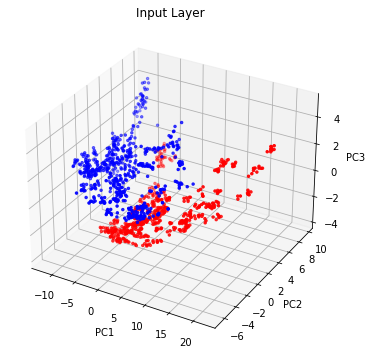

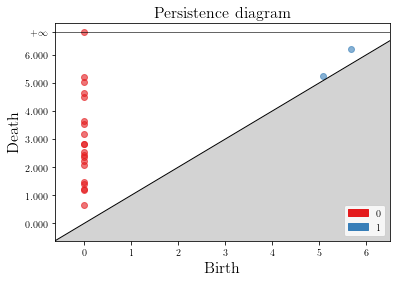

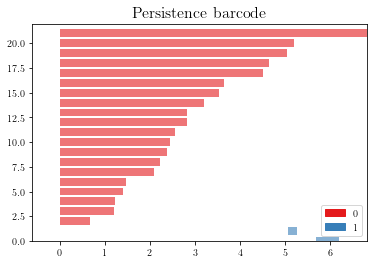

In [22]:
df = input_array_relu

pca = PCA(n_components=3)
pca.fit(df)

result=pd.DataFrame(pca.transform(df), columns=['PCA%i' % i for i in range(3)])

result['class'] = class_vector
result.head()

result_0 = result[result['class'] == 0]
result_1 = result[result['class'] == 1]

fig = plt.figure()
fig.set_size_inches(6, 6)
ax = fig.add_subplot(111, projection='3d')

ax.scatter(result_0['PCA0'], result_0['PCA1'], result_0['PCA2'], c='blue', cmap="r", s=6)
ax.scatter(result_1['PCA0'], result_1['PCA1'], result_1['PCA2'], c='red', cmap="b", s=6)

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("Input Layer")

# ******* Persistance barcode and diagram for the first 20 elements *******
rcI_relu = gd.RipsComplex(points=input_array_relu[:20]).create_simplex_tree(max_dimension=3)
rcdgmI_relu = rcI_relu.persistence()
gd.plot_persistence_diagram(rcdgmI_relu, max_intervals=0, legend=True)
gd.plot_persistence_barcode(rcdgmI_relu, max_intervals=0, legend=True)

plt.show()

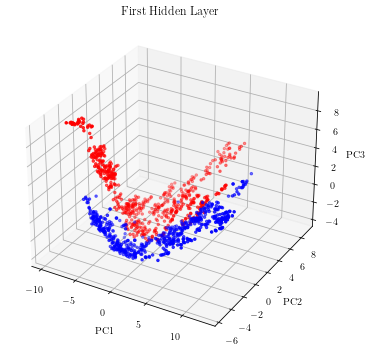

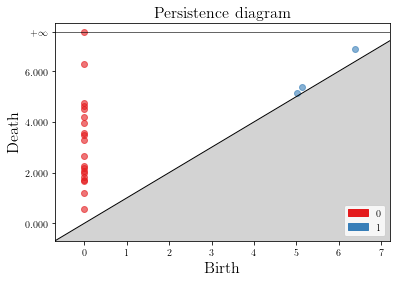

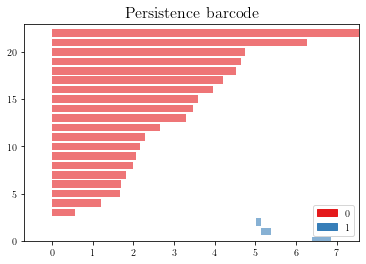

In [23]:
df1 = hidden_1_array_relu

pca = PCA(n_components=3)
pca.fit(df1)

result=pd.DataFrame(pca.transform(df1), columns=['PCA%i' % i for i in range(3)])

result['class'] = class_vector
result.head()

result_0 = result[result['class'] == 0]
result_1 = result[result['class'] == 1]

fig = plt.figure()
fig.set_size_inches(6, 6)
ax = fig.add_subplot(111, projection='3d')

ax.scatter(result_0['PCA0'], result_0['PCA1'], result_0['PCA2'], c='blue', cmap="r", s=6)
ax.scatter(result_1['PCA0'], result_1['PCA1'], result_1['PCA2'], c='red', cmap="b", s=6)

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("First Hidden Layer")

# ******* Persistance barcode and diagram for the first 20 elements *******
rcH1_relu = gd.RipsComplex(points=hidden_1_array_relu[:20]).create_simplex_tree(max_dimension=3)
rcdgmH1_relu = rcH1_relu.persistence()
gd.plot_persistence_diagram(rcdgmH1_relu, max_intervals=0, legend=True)
gd.plot_persistence_barcode(rcdgmH1_relu, max_intervals=0, legend=True)

plt.show()

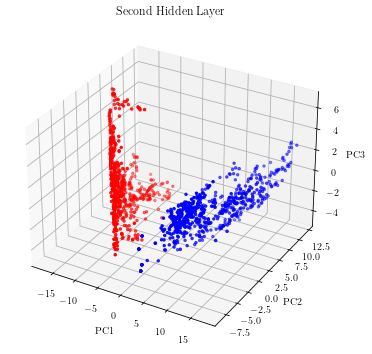

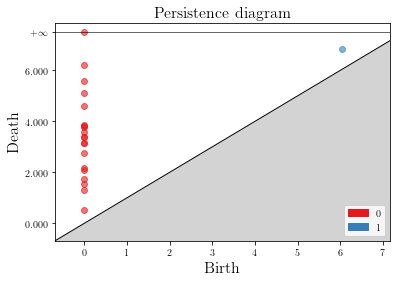

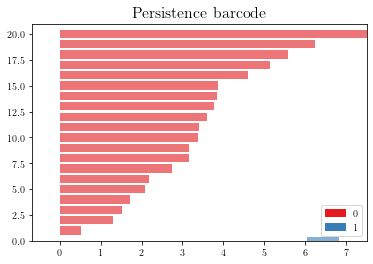

In [24]:
df1 = hidden_2_array_relu

pca = PCA(n_components=3)
pca.fit(df1)

result=pd.DataFrame(pca.transform(df1), columns=['PCA%i' % i for i in range(3)])

result['class'] = class_vector
result.head()

result_0 = result[result['class'] == 0]
result_1 = result[result['class'] == 1]

fig = plt.figure()
fig.set_size_inches(6, 6)
ax = fig.add_subplot(111, projection='3d')

ax.scatter(result_0['PCA0'], result_0['PCA1'], result_0['PCA2'], c='blue', cmap="r", s=6)
ax.scatter(result_1['PCA0'], result_1['PCA1'], result_1['PCA2'], c='red', cmap="b", s=6)

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("Second Hidden Layer")

# ******* Persistance barcode and diagram for the first 20 elements *******
rcH2_relu = gd.RipsComplex(points=hidden_2_array_relu[:20]).create_simplex_tree(max_dimension=3)
rcdgmH2_relu = rcH2_relu.persistence()
gd.plot_persistence_diagram(rcdgmH2_relu, max_intervals=0, legend=True)
gd.plot_persistence_barcode(rcdgmH2_relu, max_intervals=0, legend=True)

plt.show()

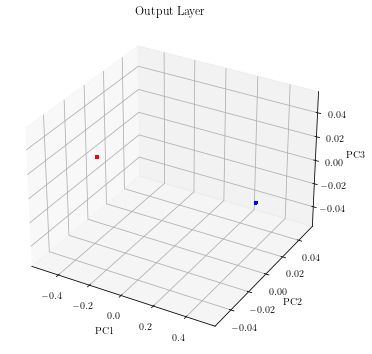

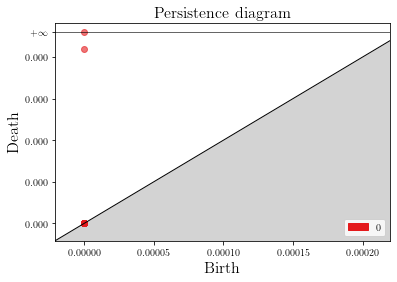

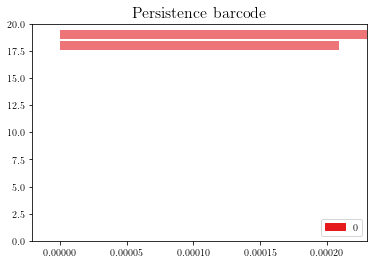

In [25]:
df1 = output_array_relu

pca = PCA(n_components=1)
pca.fit(df1)

result=pd.DataFrame(pca.transform(df1), columns=['PCA%i' % i for i in range(1)])

result['class'] = class_vector
result.head()

result_0 = result[result['class'] == 0]
result_1 = result[result['class'] == 1]

fig = plt.figure()
fig.set_size_inches(6, 6)
ax = fig.add_subplot(111, projection='3d')

zeros = np.empty(len(result_0))
zeros.fill(0)

ones = np.empty(len(result_1))
ones.fill(1)

ax.scatter(result_0['PCA0'], zeros, zeros, c='blue', s=6) # Counterfit
ax.scatter(result_1['PCA0'], zeros, zeros, c='red', s=6) # Genuine

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("Output Layer")

# ******* Persistance barcode and diagram for the first 20 elements *******
rcO_relu = gd.RipsComplex(points=output_array_relu[:20]).create_simplex_tree(max_dimension=3)
rcdgmO_relu = rcO_relu.persistence()
gd.plot_persistence_diagram(rcdgmO_relu, max_intervals=0, legend=True)
gd.plot_persistence_barcode(rcdgmO_relu, max_intervals=0, legend=True)

plt.show()

We now follow the same procedure, starting with the training, but with a hyperbolic tangent activation function raher than the ReLU activation function. All other aspects of the two networks are the same. The only difference is the activation function used. Thus, no markdown cells will be used in this section as everything is the same as we have previously seen. 

In [26]:
layers_tanh = {"input": [4, ID],
          "hidden_1": [20, tf.keras.activations.tanh],
          "hidden_2": [20, tf.keras.activations.tanh],
          "output": [1, tf.keras.activations.sigmoid]}

In [27]:
model_tanh = keras.Sequential()

model_tanh.add(tf.keras.layers.Dense(layers_tanh["hidden_1"][0], layers_tanh["hidden_1"][1], input_dim=layers_tanh["input"][0])) 
model_tanh.add(tf.keras.layers.Dense(layers_tanh["hidden_2"][0], layers_tanh["hidden_2"][1]))
model_tanh.add(tf.keras.layers.Dense(layers_tanh["output"][0], layers_tanh["output"][1]))

opt = keras.optimizers.Adam()
loss = keras.losses.BinaryCrossentropy()

model_tanh.compile(optimizer=opt, loss=loss, metrics=['accuracy'])
model_tanh.fit(X_train, y_train, epochs = 200, batch_size=32)

Epoch 1/200
31/31 [==============================] - 0s 6ms/step - loss: 0.5830 - accuracy: 0.7090
Epoch 2/200
31/31 [==============================] - 0s 5ms/step - loss: 0.3358 - accuracy: 0.9191
Epoch 3/200
31/31 [==============================] - 0s 5ms/step - loss: 0.2027 - accuracy: 0.9580
Epoch 4/200
31/31 [==============================] - 0s 5ms/step - loss: 0.1282 - accuracy: 0.9795
Epoch 5/200
31/31 [==============================] - 0s 5ms/step - loss: 0.0877 - accuracy: 0.9918
Epoch 6/200
31/31 [==============================] - 0s 5ms/step - loss: 0.0642 - accuracy: 0.9877
Epoch 7/200
31/31 [==============================] - 0s 5ms/step - loss: 0.0493 - accuracy: 0.9959
Epoch 8/200
31/31 [==============================] - 0s 5ms/step - loss: 0.0395 - accuracy: 0.9949
Epoch 9/200
31/31 [==============================] - 0s 5ms/step - loss: 0.0326 - accuracy: 0.9969
Epoch 10/200
31/31 [==============================] - 0s 5ms/step - loss: 0.0277 - accuracy: 0.9959
Epoch 11/

31/31 [==============================] - 0s 5ms/step - loss: 5.0364e-04 - accuracy: 1.0000
Epoch 83/200
31/31 [==============================] - 0s 5ms/step - loss: 4.8646e-04 - accuracy: 1.0000
Epoch 84/200
31/31 [==============================] - 0s 5ms/step - loss: 4.7681e-04 - accuracy: 1.0000
Epoch 85/200
31/31 [==============================] - 0s 5ms/step - loss: 4.5564e-04 - accuracy: 1.0000
Epoch 86/200
31/31 [==============================] - 0s 5ms/step - loss: 4.4724e-04 - accuracy: 1.0000
Epoch 87/200
31/31 [==============================] - 0s 5ms/step - loss: 4.3215e-04 - accuracy: 1.0000
Epoch 88/200
31/31 [==============================] - 0s 5ms/step - loss: 4.2046e-04 - accuracy: 1.0000
Epoch 89/200
31/31 [==============================] - 0s 5ms/step - loss: 4.1101e-04 - accuracy: 1.0000
Epoch 90/200
31/31 [==============================] - 0s 5ms/step - loss: 3.9820e-04 - accuracy: 1.0000
Epoch 91/200
31/31 [==============================] - 0s 5ms/step - loss: 3.8

31/31 [==============================] - 0s 5ms/step - loss: 7.7847e-05 - accuracy: 1.0000
Epoch 161/200
31/31 [==============================] - 0s 5ms/step - loss: 7.6592e-05 - accuracy: 1.0000
Epoch 162/200
31/31 [==============================] - 0s 5ms/step - loss: 7.4945e-05 - accuracy: 1.0000
Epoch 163/200
31/31 [==============================] - 0s 5ms/step - loss: 7.3434e-05 - accuracy: 1.0000
Epoch 164/200
31/31 [==============================] - 0s 5ms/step - loss: 7.2476e-05 - accuracy: 1.0000
Epoch 165/200
31/31 [==============================] - 0s 5ms/step - loss: 7.1069e-05 - accuracy: 1.0000
Epoch 166/200
31/31 [==============================] - 0s 5ms/step - loss: 6.9465e-05 - accuracy: 1.0000
Epoch 167/200
31/31 [==============================] - 0s 5ms/step - loss: 6.8331e-05 - accuracy: 1.0000
Epoch 168/200
31/31 [==============================] - 0s 5ms/step - loss: 6.6684e-05 - accuracy: 1.0000
Epoch 169/200
31/31 [==============================] - 0s 5ms/step - 

In [28]:
# model_tanh.save("model_tanh", overwrite=True, include_optimizer=True)

model_saved_tanh = keras.models.load_model("model_tanh")

In [29]:
weights_tanh = [[
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, 0],
    [0, 0, 0, 1]]]
biases_tanh = [[0, 0, 0, 0]]

for layer_index, layer_val in enumerate(model_saved_tanh.layers):
    weights_tanh.append(layer_val.get_weights()[0])
    biases_tanh.append(layer_val.get_weights()[1])

In [30]:
ypred = model_saved_tanh.predict(X)
yhat = (ypred > 0.01).flatten().astype(int)

score = sklearn.metrics.accuracy_score(y, yhat)
print('Accuracy: %.3f' % score)

Accuracy: 1.000


In [31]:
input_array_tanh = []
hidden_1_array_tanh = []
hidden_2_array_tanh = []
output_array_tanh = []

In [32]:
def get_output_vector_tanh(input_vector):
    output_vector = [input_vector.tolist()]
    
    for index, (key, value) in enumerate(layers_tanh.items()):
        output_vector.append(value[1](np.dot(output_vector[index], weights_tanh[index]) + biases_tanh[index]))
        
    return output_vector

In [33]:
output_vector_tanh = []
class_vector = np.array(df_target.values.tolist())

for index, row in df_features.iterrows():
    output_vector_tanh.append(get_output_vector_tanh(row))

In [34]:
for index, row in enumerate(output_vector_tanh):
    input_array_tanh.append(output_vector_tanh[index][1])
    hidden_1_array_tanh.append(output_vector_tanh[index][2])
    hidden_2_array_tanh.append(output_vector_tanh[index][3])
    output_array_tanh.append(output_vector_tanh[index][4])

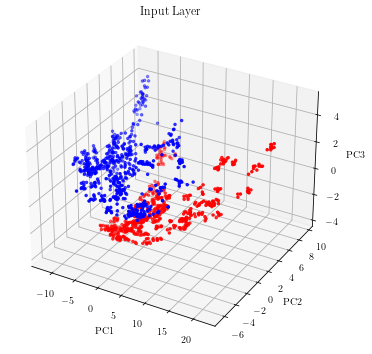

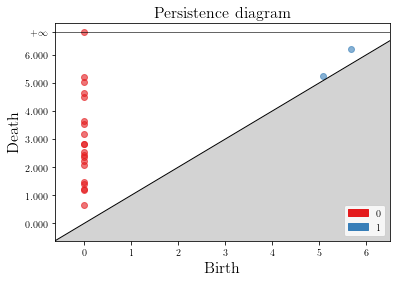

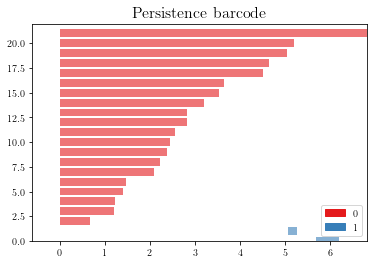

In [35]:
df = input_array_tanh

pca = PCA(n_components=3)
pca.fit(df)

result=pd.DataFrame(pca.transform(df), columns=['PCA%i' % i for i in range(3)])

result['class'] = class_vector
result.head()

result_0 = result[result['class'] == 0]
result_1 = result[result['class'] == 1]

fig = plt.figure()
fig.set_size_inches(6, 6)
ax = fig.add_subplot(111, projection='3d')

ax.scatter(result_0['PCA0'], result_0['PCA1'], result_0['PCA2'], c='blue', cmap="r", s=6)
ax.scatter(result_1['PCA0'], result_1['PCA1'], result_1['PCA2'], c='red', cmap="b", s=6)

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("Input Layer")

# ******* Persistance barcode and diagram for the first 20 elements *******
rcI_tanh = gd.RipsComplex(points=input_array_tanh[:20]).create_simplex_tree(max_dimension=3)
rcdgmI_tanh = rcI_tanh.persistence()
gd.plot_persistence_diagram(rcdgmI_tanh, max_intervals=0, legend=True)
gd.plot_persistence_barcode(rcdgmI_tanh, max_intervals=0, legend=True)

plt.show()

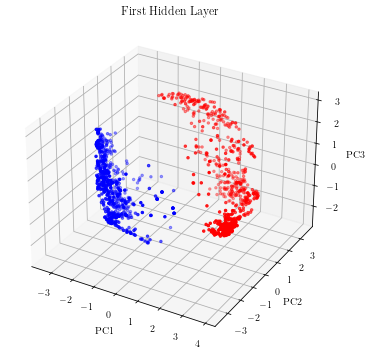

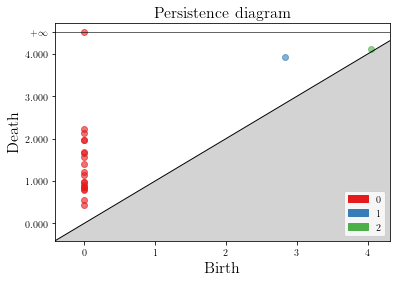

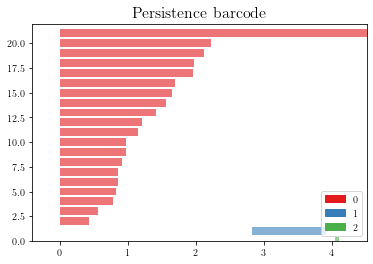

In [36]:
df1 = hidden_1_array_tanh

pca = PCA(n_components=3)
pca.fit(df1)

result=pd.DataFrame(pca.transform(df1), columns=['PCA%i' % i for i in range(3)])

result['class'] = class_vector
result.head()

result_0 = result[result['class'] == 0]
result_1 = result[result['class'] == 1]

fig = plt.figure()
fig.set_size_inches(6, 6)
ax = fig.add_subplot(111, projection='3d')

ax.scatter(result_0['PCA0'], result_0['PCA1'], result_0['PCA2'], c='blue', cmap="r", s=6)
ax.scatter(result_1['PCA0'], result_1['PCA1'], result_1['PCA2'], c='red', cmap="b", s=6)

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("First Hidden Layer")

# ******* Persistance barcode and diagram for the first 20 elements *******
rcH1_tanh = gd.RipsComplex(points=hidden_1_array_tanh[:20]).create_simplex_tree(max_dimension=3)
rcdgmH1_tanh = rcH1_tanh.persistence()
gd.plot_persistence_diagram(rcdgmH1_tanh, max_intervals=0, legend=True)
gd.plot_persistence_barcode(rcdgmH1_tanh, max_intervals=0, legend=True)

plt.show()

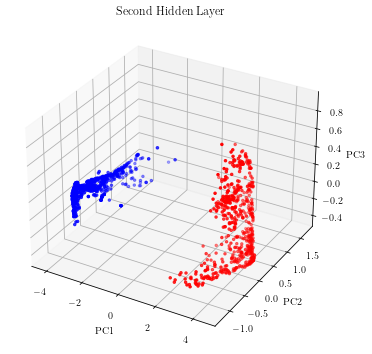

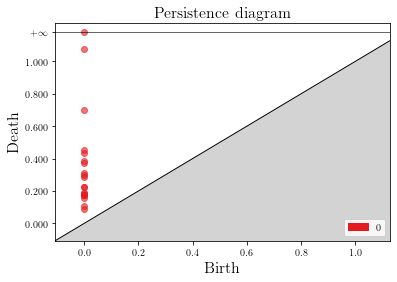

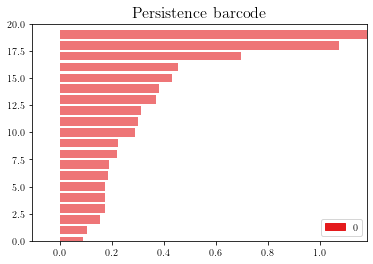

In [37]:
df1 = hidden_2_array_tanh

pca = PCA(n_components=3)
pca.fit(df1)

result=pd.DataFrame(pca.transform(df1), columns=['PCA%i' % i for i in range(3)])

result['class'] = class_vector
result.head()

result_0 = result[result['class'] == 0]
result_1 = result[result['class'] == 1]

fig = plt.figure()
fig.set_size_inches(6, 6)
ax = fig.add_subplot(111, projection='3d')

ax.scatter(result_0['PCA0'], result_0['PCA1'], result_0['PCA2'], c='blue', cmap="r", s=6)
ax.scatter(result_1['PCA0'], result_1['PCA1'], result_1['PCA2'], c='red', cmap="b", s=6)

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("Second Hidden Layer")

# ******* Persistance barcode and diagram for the first 20 elements *******
rcH2_tanh = gd.RipsComplex(points=hidden_2_array_tanh[:20]).create_simplex_tree(max_dimension=3)
rcdgmH2_tanh = rcH2_tanh.persistence()
gd.plot_persistence_diagram(rcdgmH2_tanh, max_intervals=0, legend=True)
gd.plot_persistence_barcode(rcdgmH2_tanh, max_intervals=0, legend=True)

plt.show()

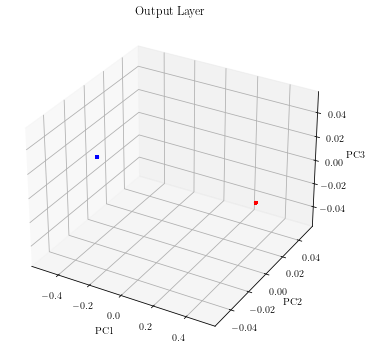

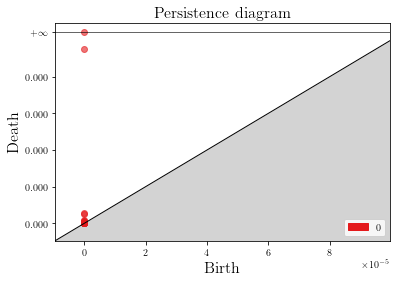

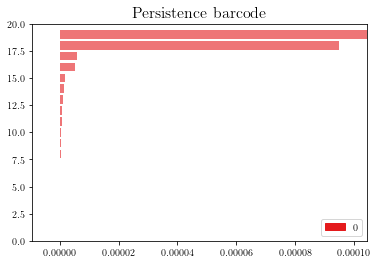

In [38]:
df1 = output_array_tanh

pca = PCA(n_components=1)
pca.fit(df1)

result=pd.DataFrame(pca.transform(df1), columns=['PCA%i' % i for i in range(1)])

result['class'] = class_vector
result.head()

result_0 = result[result['class'] == 0]
result_1 = result[result['class'] == 1]

fig = plt.figure()
fig.set_size_inches(6, 6)
ax = fig.add_subplot(111, projection='3d')

zeros = np.empty(len(result_0))
zeros.fill(0)

ones = np.empty(len(result_1))
ones.fill(1)

ax.scatter(result_0['PCA0'], zeros, zeros, c='blue', s=6) # Counterfit
ax.scatter(result_1['PCA0'], zeros, zeros, c='red', s=6) # Genuine

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("Output Layer")

# ******* Persistance barcode and diagram for the first 20 elements *******
rcO_tanh = gd.RipsComplex(points=output_array_tanh[:20]).create_simplex_tree(max_dimension=3)
rcdgmO_tanh = rcO_tanh.persistence()
gd.plot_persistence_diagram(rcdgmO_tanh, max_intervals=0, legend=True)
gd.plot_persistence_barcode(rcdgmO_tanh, max_intervals=0, legend=True)

plt.show()